## Fonte dos dados e dicionário

[Dados](https://www.kaggle.com/datasets/utkarshx27/breast-cancer-dataset-used-royston-and-altman)

Será utilizada, neste estudo, a base de dados intitulada "Breast Cancer Dataset 
used  by  Royston  and  Altman",  disponibilizada  na  plataforma  Kaggle.  Esse 
conjunto  de  dados  reúne  informações  clínicas de pacientes com diagnóstico 
confirmado de câncer de mama, incluindo variáveis como idade, estadiamento 
da doença, presença de metástases, entre outras características relevantes ao 
prognóstico

### Dicionário de dados

| Coluna     | Descrição                                                                 |
|------------|---------------------------------------------------------------------------|
| pid        | Identificador do paciente                                                 |
| age        | Idade, em anos                                                            |
| meno       | Status menopausal (0 = pré-menopausa, 1 = pós-menopausa)                 |
| size       | Tamanho do tumor, em milímetros                                           |
| grade      | Grau do tumor                                                             |
| nodes      | Número de linfonodos positivos                                            |
| pgr        | Receptores de progesterona (fmol/l)                                       |
| er         | Receptores de estrogênio (fmol/l)                                         |
| hormon     | Terapia hormonal (0 = não, 1 = sim)                                       |
| rfstime    | Tempo livre de recorrência; dias até a primeira recorrência, morte ou último acompanhamento |
| status     | 0 = vivo sem recorrência, 1 = recorrência ou morte                       |



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, WeibullFitter, LogNormalFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import restricted_mean_survival_time

datapath = "data/gbsg.csv"

df = pd.read_csv(datapath)
df.drop(columns=['pid'], inplace=True)

In [5]:
event_col = ['status']
time_col = ['rfstime']
id_col = ['pid']

# 1. Analise exploratória dos dados

Evento em análise.
Recorrência ou morte

Censura: 
Para essa análise exploratória de dados, vale ressaltar que em todos os casos, são pacientes com nódulo positivo de câncer.



In [100]:
df.head()

,age,meno,size,grade,nodes,pgr,er,hormon,rfstime,status,age_cat
0,49,0,18,2,2,0,0,0,1838,0,Adulto (40–59)
1,55,1,20,3,16,0,0,0,403,1,Adulto (40–59)
2,56,1,40,3,3,0,0,0,1603,0,Adulto (40–59)
3,45,0,25,3,1,0,4,0,177,0,Adulto (40–59)
4,65,1,30,2,5,0,36,1,1855,0,Idoso (60+)


In [101]:
df.isna().sum()

age        0
meno       0
size       0
grade      0
nodes      0
pgr        0
er         0
hormon     0
rfstime    0
status     0
age_cat    0
dtype: int64

In [102]:
df.min()

age                 21
meno                 0
size                 3
grade                1
nodes                1
pgr                  0
er                   0
hormon               0
rfstime              8
status               0
age_cat    Jovem (<40)
dtype: object

In [103]:
df.max()

age                 80
meno                 1
size               120
grade                3
nodes               51
pgr               2380
er                1144
hormon               1
rfstime           2659
status               1
age_cat    Idoso (60+)
dtype: object

## 1.1. Integridade dos dados

- Verificando dados faltantes
- Verificando o tipo de dados (original)

In [104]:
df.shape

(686, 11)

In [105]:
df.isna().sum()

age        0
meno       0
size       0
grade      0
nodes      0
pgr        0
er         0
hormon     0
rfstime    0
status     0
age_cat    0
dtype: int64

In [106]:
df.dtypes

age           int64
meno          int64
size          int64
grade         int64
nodes         int64
pgr           int64
er            int64
hormon        int64
rfstime       int64
status        int64
age_cat    category
dtype: object

## 1.2. Explorando as features isoladamente

Analisando as features isoladamente
- Idade dos pacientes
- Status de menopausa
- Tamanho do tumor
- Grau do tumor
- Número de linfonodos positivos
- Receptores de progesterona
- Receptores de estrogênio
- Terapia hormonal
- Tempo livre de recorrência, dias até a primeira ocorrência, morte ou último acompanhamento
- Status do evento

In [8]:
def setup_axes(ax: plt.Axes, title:str, remove_spines: list | str = [], remove_xticks: bool = False, remove_yticks: bool = False, title_loc: str = 'center') -> plt.Axes:
    ax.set_title(title, loc=title_loc)
    if isinstance(remove_spines, list):
        for spine in remove_spines:
            ax.spines[spine].set_visible(False)
    elif isinstance(remove_spines, str):
        if remove_spines == 'all':
            for spine in ["top", "right", "left", "bottom"]:
                ax.spines[spine].set_visible(False)
    if remove_xticks:
        ax.set_xticks([])
    if remove_yticks:
        ax.set_yticks([])
    return ax

def create_subplot_list(fig:plt.Figure, gs: plt.GridSpec,  slices: list[tuple[slice | int, slice | int]]) -> list[plt.Axes]:
    axes = [None for _ in range(len(slices))]
    for i, s in enumerate(slices):
        axes[i] = fig.add_subplot(gs[s[0], s[1]])
    return axes

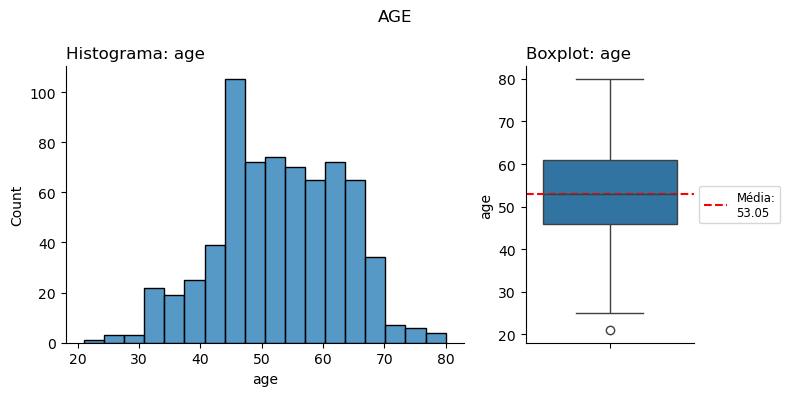

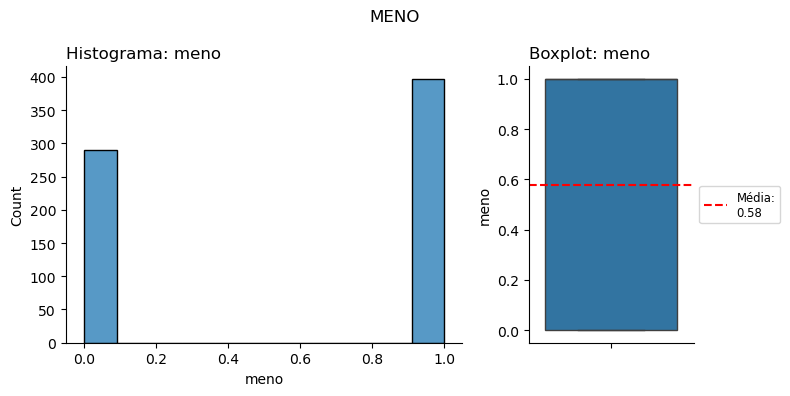

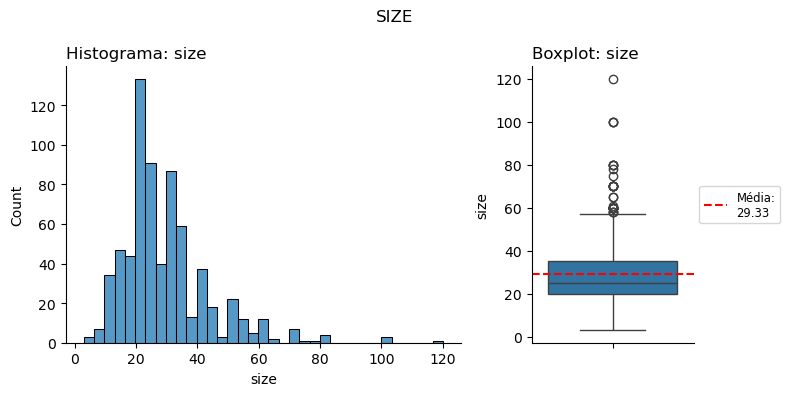

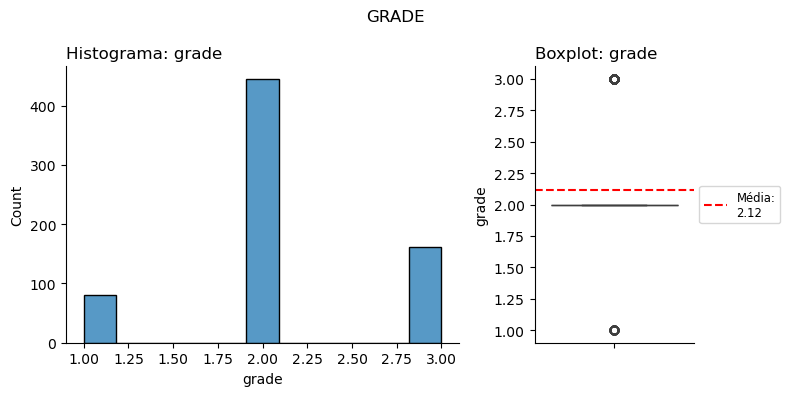

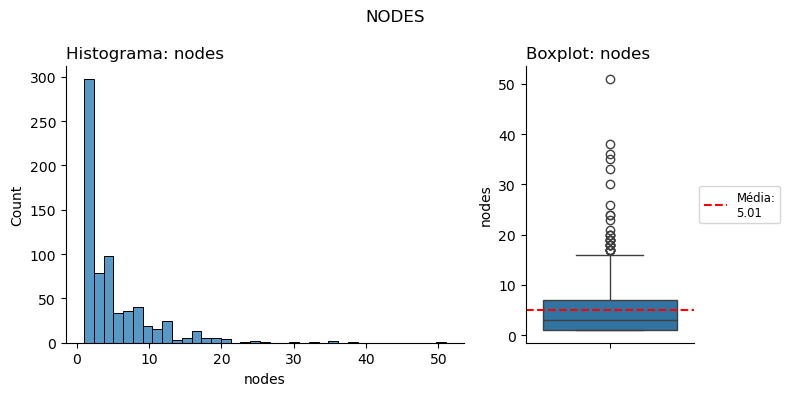

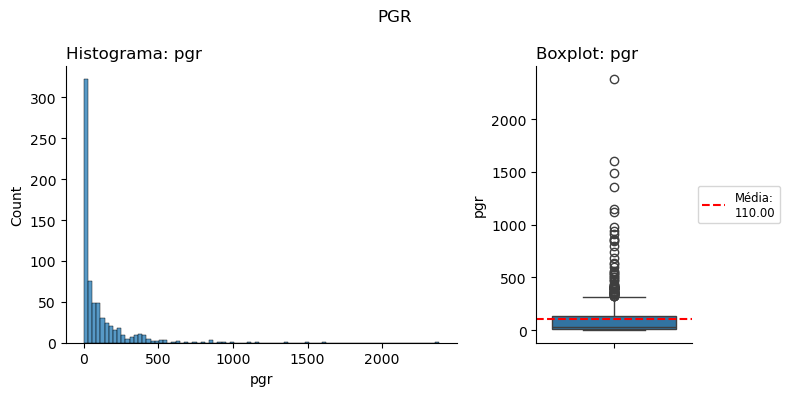

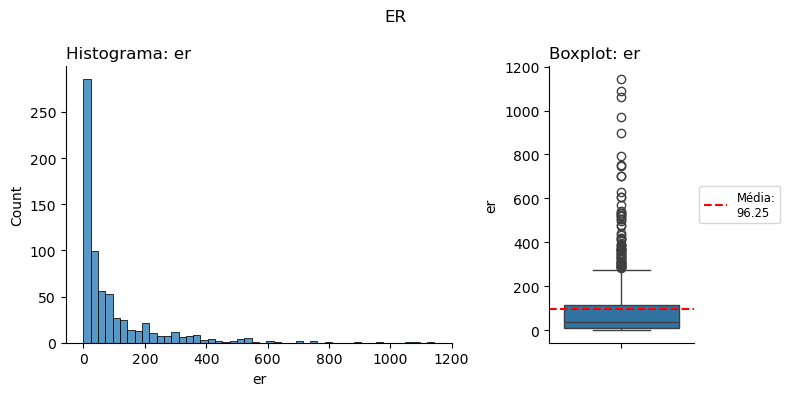

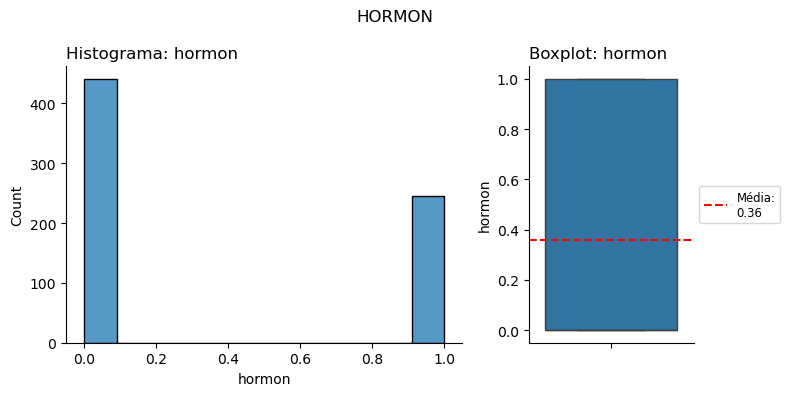

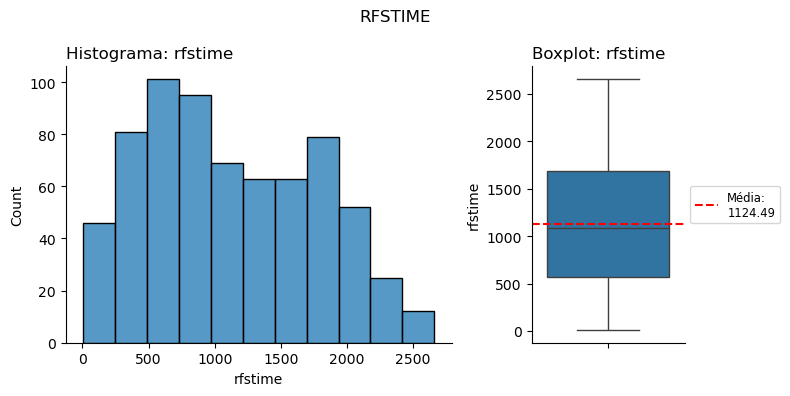

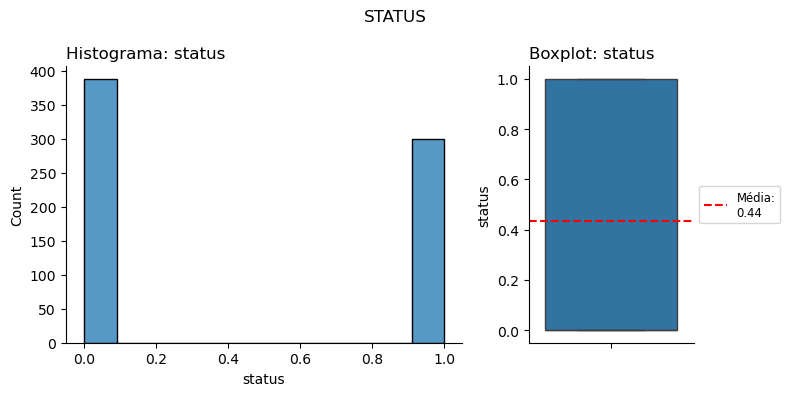

In [34]:
num_cols = ['age','meno','size', 'grade', 'nodes', 'pgr', 'er','hormon','rfstime','status']

for col in num_cols:
    fig = plt.figure(figsize=(8, 4))
    fig.suptitle(col.upper())
    
    gs = fig.add_gridspec(1, 3)
    axes = create_subplot_list(
        fig=fig,
        gs=gs,
        slices= [
            (0, slice(0,2)),
            (0, 2)
        ]
    )

    sns.histplot(df, x=col, ax=axes[0])
    sns.boxplot(df, y=col, ax=axes[1])

    mean = df[col].mean()
    axes[1].axhline(mean, color='red', linestyle='--', label=f"Média:\n{mean:.2f}")
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),  fontsize='small')

    setup_axes(axes[0], title=f"Histograma: {col}", remove_spines=['top','right'], title_loc='left')
    setup_axes(axes[1], title=f"Boxplot: {col}", remove_spines=['top','right'], title_loc='left')

    plt.tight_layout()
    plt.show()
    fig.savefig(fname=f"images/features/{col}_hist_box_plot.png")

## 1.2. Explorando a relação entre as features e o status do evento

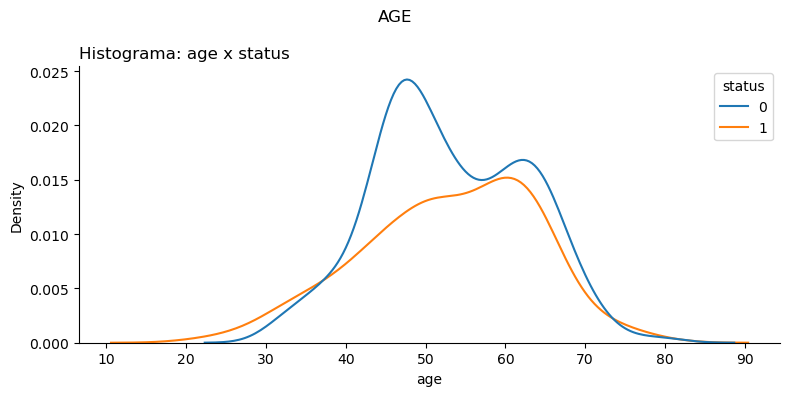

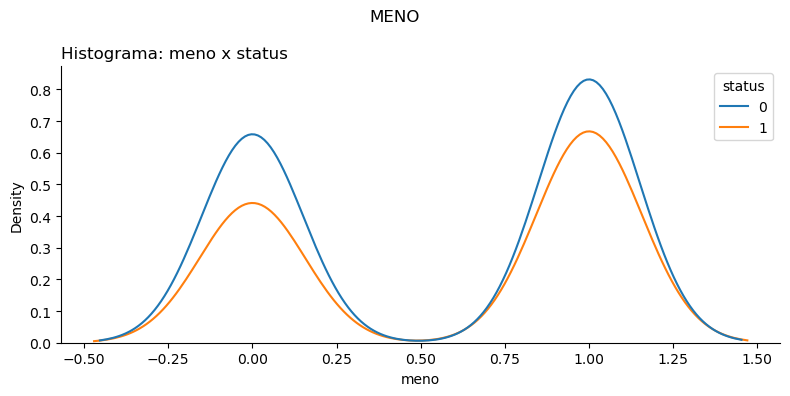

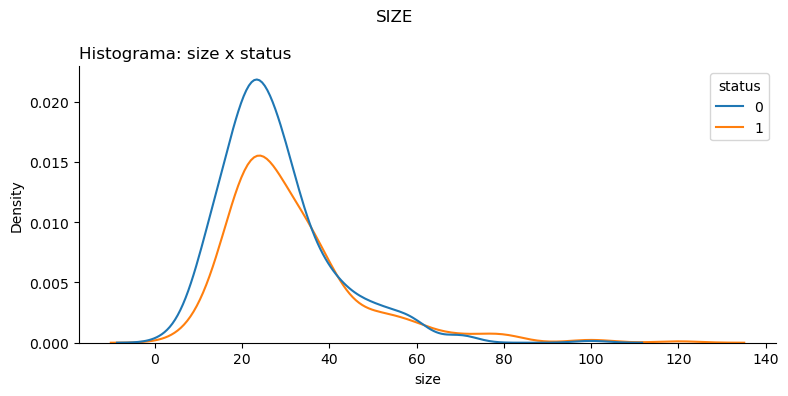

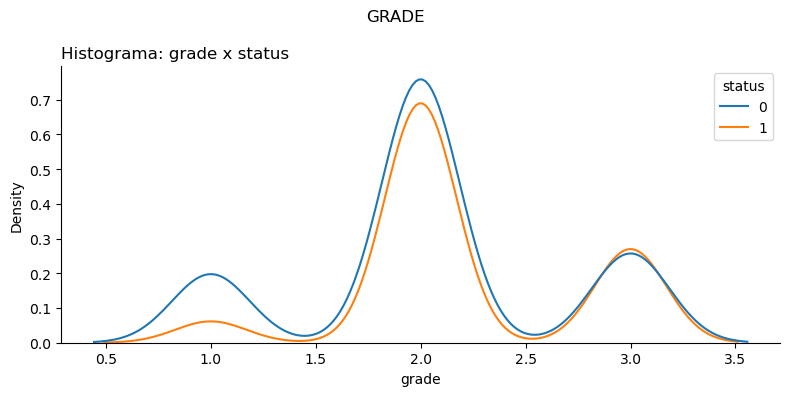

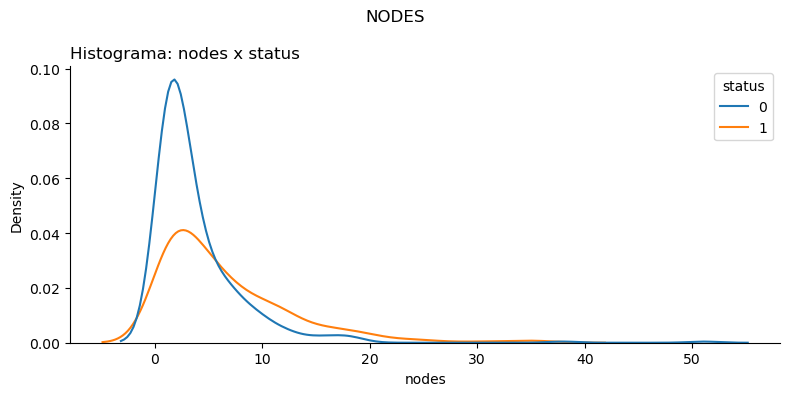

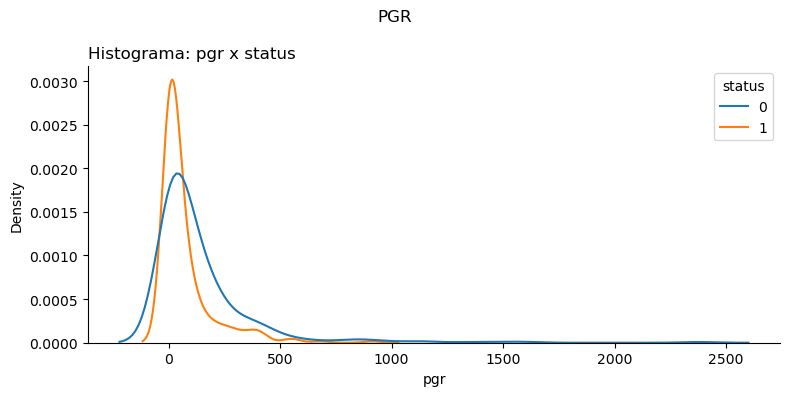

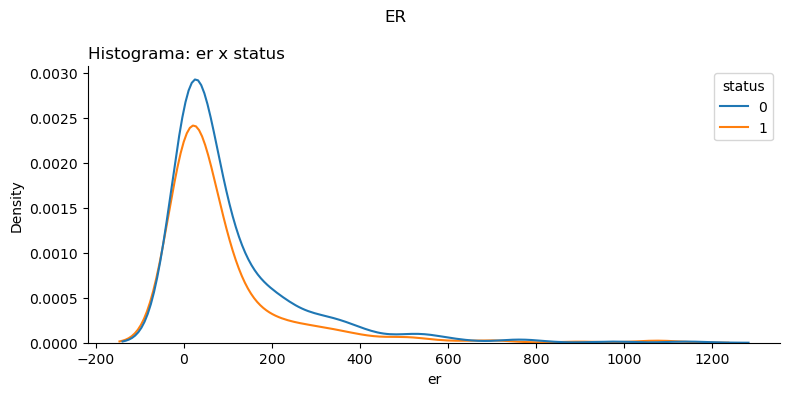

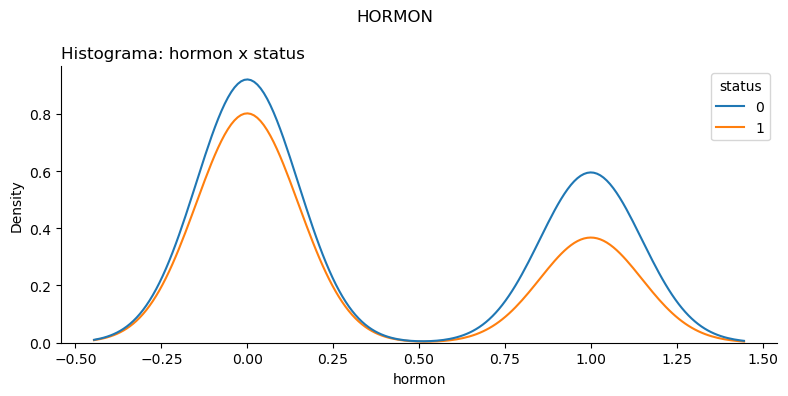

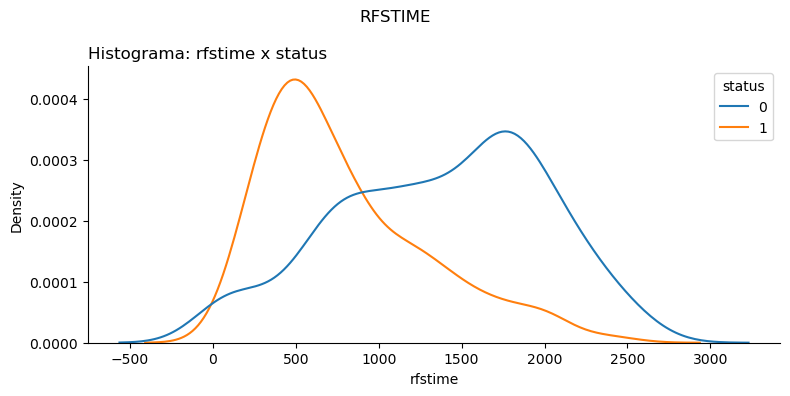

C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_41276\2018441064.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df, x=col, hue='status',ax=axes[0])


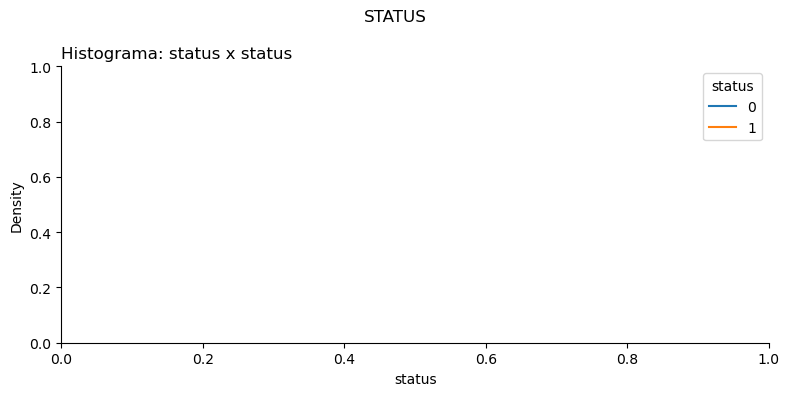

In [35]:
num_cols = ['age','meno','size', 'grade', 'nodes', 'pgr', 'er','hormon','rfstime','status']


for col in num_cols:
    fig = plt.figure(figsize=(8, 4))
    fig.suptitle(col.upper())
    gs = fig.add_gridspec(1, 1)
    axes = create_subplot_list(
        fig=fig,
        gs=gs,
        slices= [
            (0, 0)
        ]
    )

    sns.kdeplot(df, x=col, hue='status',ax=axes[0])
    setup_axes(axes[0], title=f"Histograma: {col} x status", remove_spines=['top','right'], title_loc='left')

    plt.tight_layout()
    plt.show()
    fig.savefig(fname=f"images/features_x_status/kde_plot_features_x_status_{col}.png")

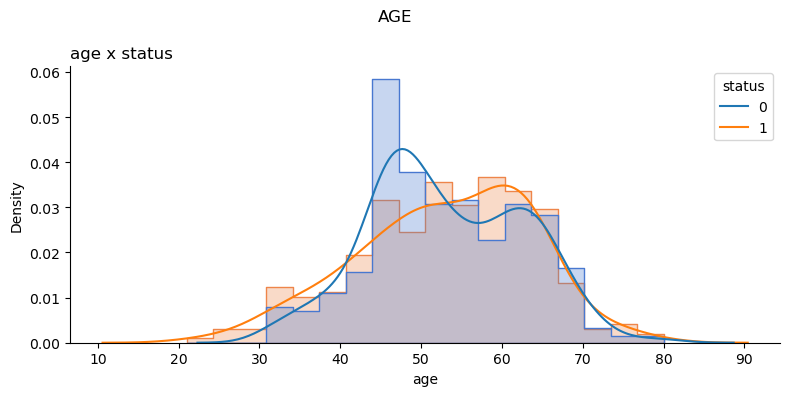

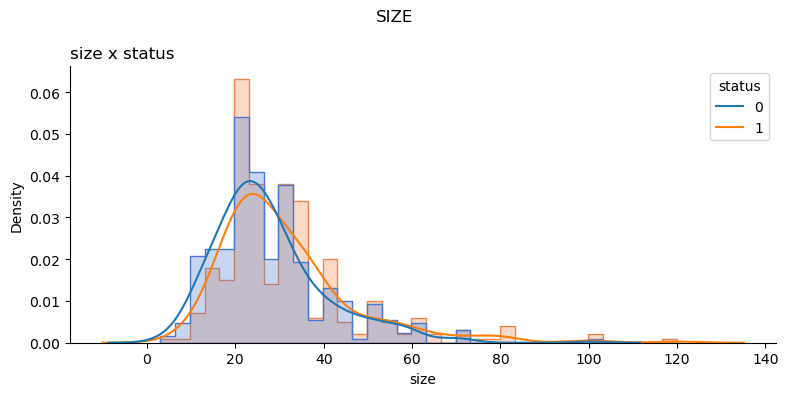

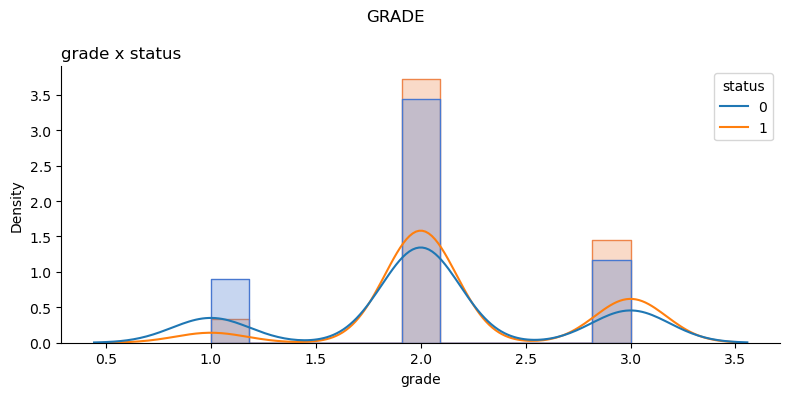

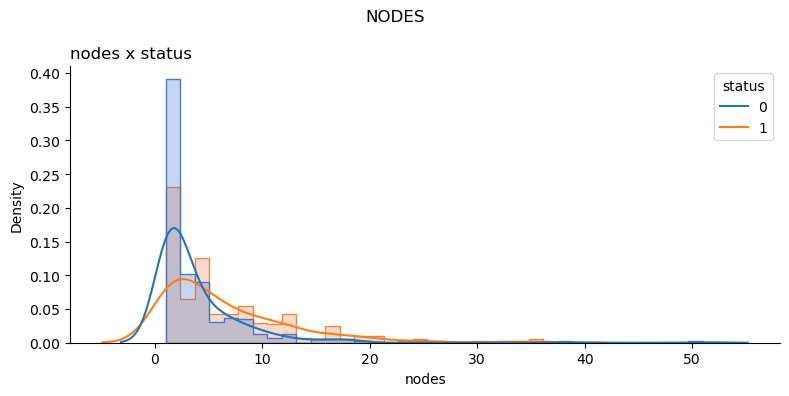

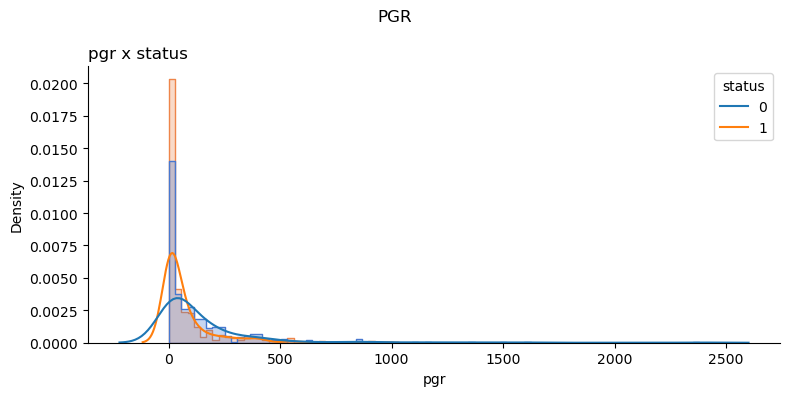

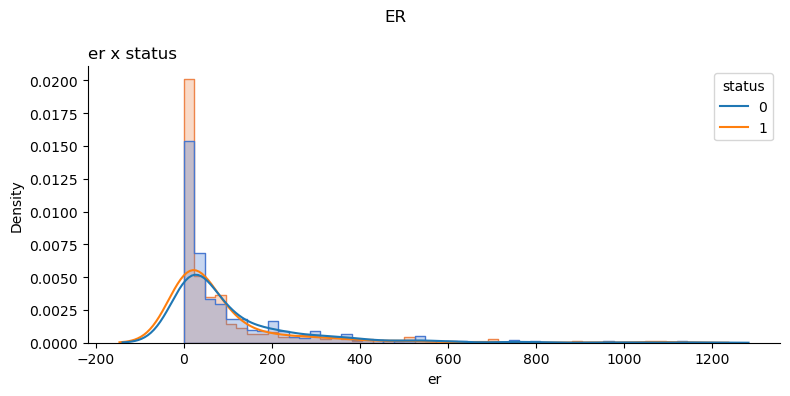

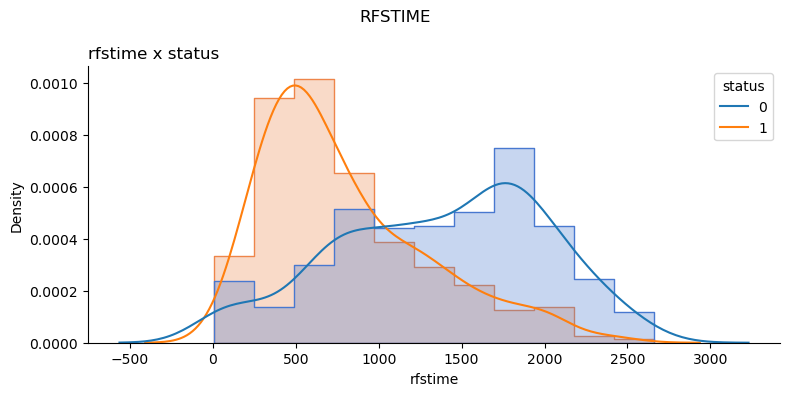

C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_41276\998907174.py:29: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


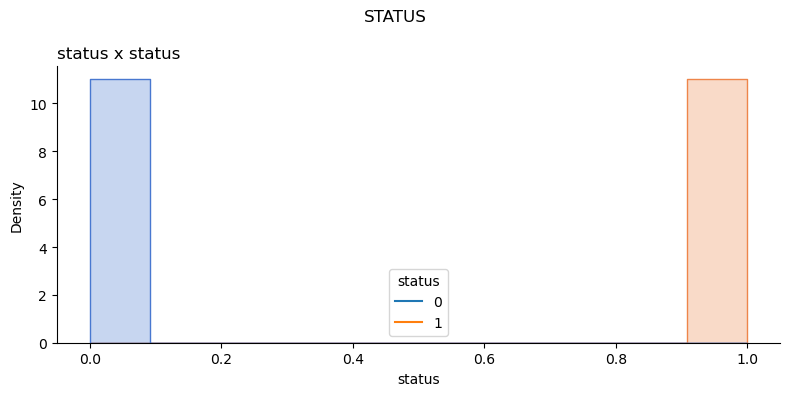

In [37]:
num_cols = ['age', 'size', 'grade', 'nodes', 'pgr', 'er', 'rfstime', 'status']

for col in num_cols:
    fig = plt.figure(figsize=(8, 4))
    fig.suptitle(col.upper())
    gs = fig.add_gridspec(1, 1)
    axes = create_subplot_list(
        fig=fig,
        gs=gs,
        slices=[(0, 0)]
    )

    ax = axes[0]

    # Adiciona histograma
    sns.histplot(
        data=df,
        x=col,
        hue='status',
        stat='density',   # importante para combinar com a escala da kde
        element='step',   # você pode trocar por 'poly' ou 'bars' se quiser
        common_norm=False,  # para que cada hue tenha sua própria densidade
        palette='muted',
        ax=ax,
        alpha=0.3          # deixa mais transparente para visualizar bem a KDE
    )

    # Adiciona KDE
    sns.kdeplot(
        data=df,
        x=col,
        hue='status',
        common_norm=False,
        ax=ax
    )

    setup_axes(ax, title=f"{col} x status", remove_spines=['top', 'right'], title_loc='left')

    plt.tight_layout()
    plt.show()
    fig.savefig(fname=f"images/features_x_status_bins/kde_hist_plot_features_x_status_{col}.png")

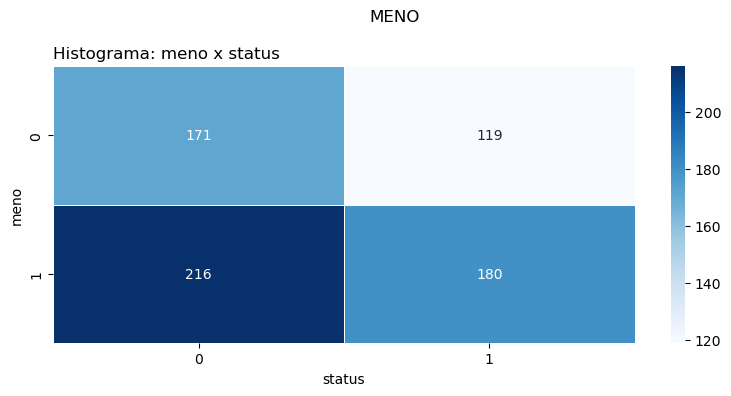

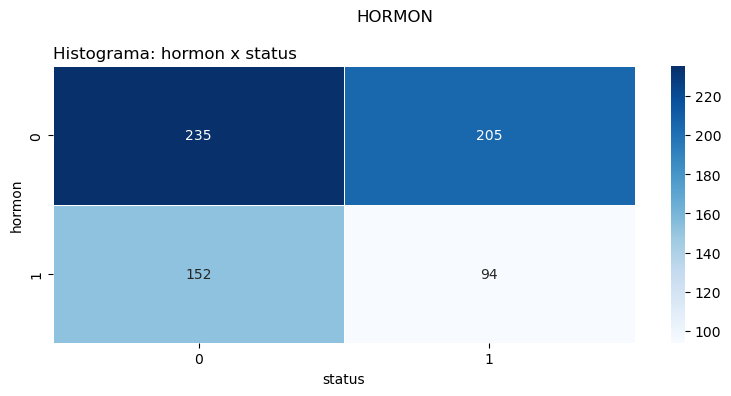

In [11]:
boolean_cols = ['meno','hormon']

for col in boolean_cols:
    fig = plt.figure(figsize=(8, 4))
    fig.suptitle(col.upper())
    gs = fig.add_gridspec(1, 1)
    axes = create_subplot_list(
        fig=fig,
        gs=gs,
        slices= [
            (0, 0)
        ]
    )

    # Cria tabela de contingência: col vs status
    ctab = pd.crosstab(df[col], df['status'])

    sns.heatmap(ctab, annot=True, fmt=".0f", cmap="Blues", ax=axes[0],linecolor='white',linewidths=0.5)
    setup_axes(axes[0], title=f"Histograma: {col} x status", title_loc='left')

    plt.tight_layout()
    plt.show()
    fig.savefig(fname=f"images/features_x_status/heatmap_plot_features_x_status_{col}.png")

### Correlação entre variáveis

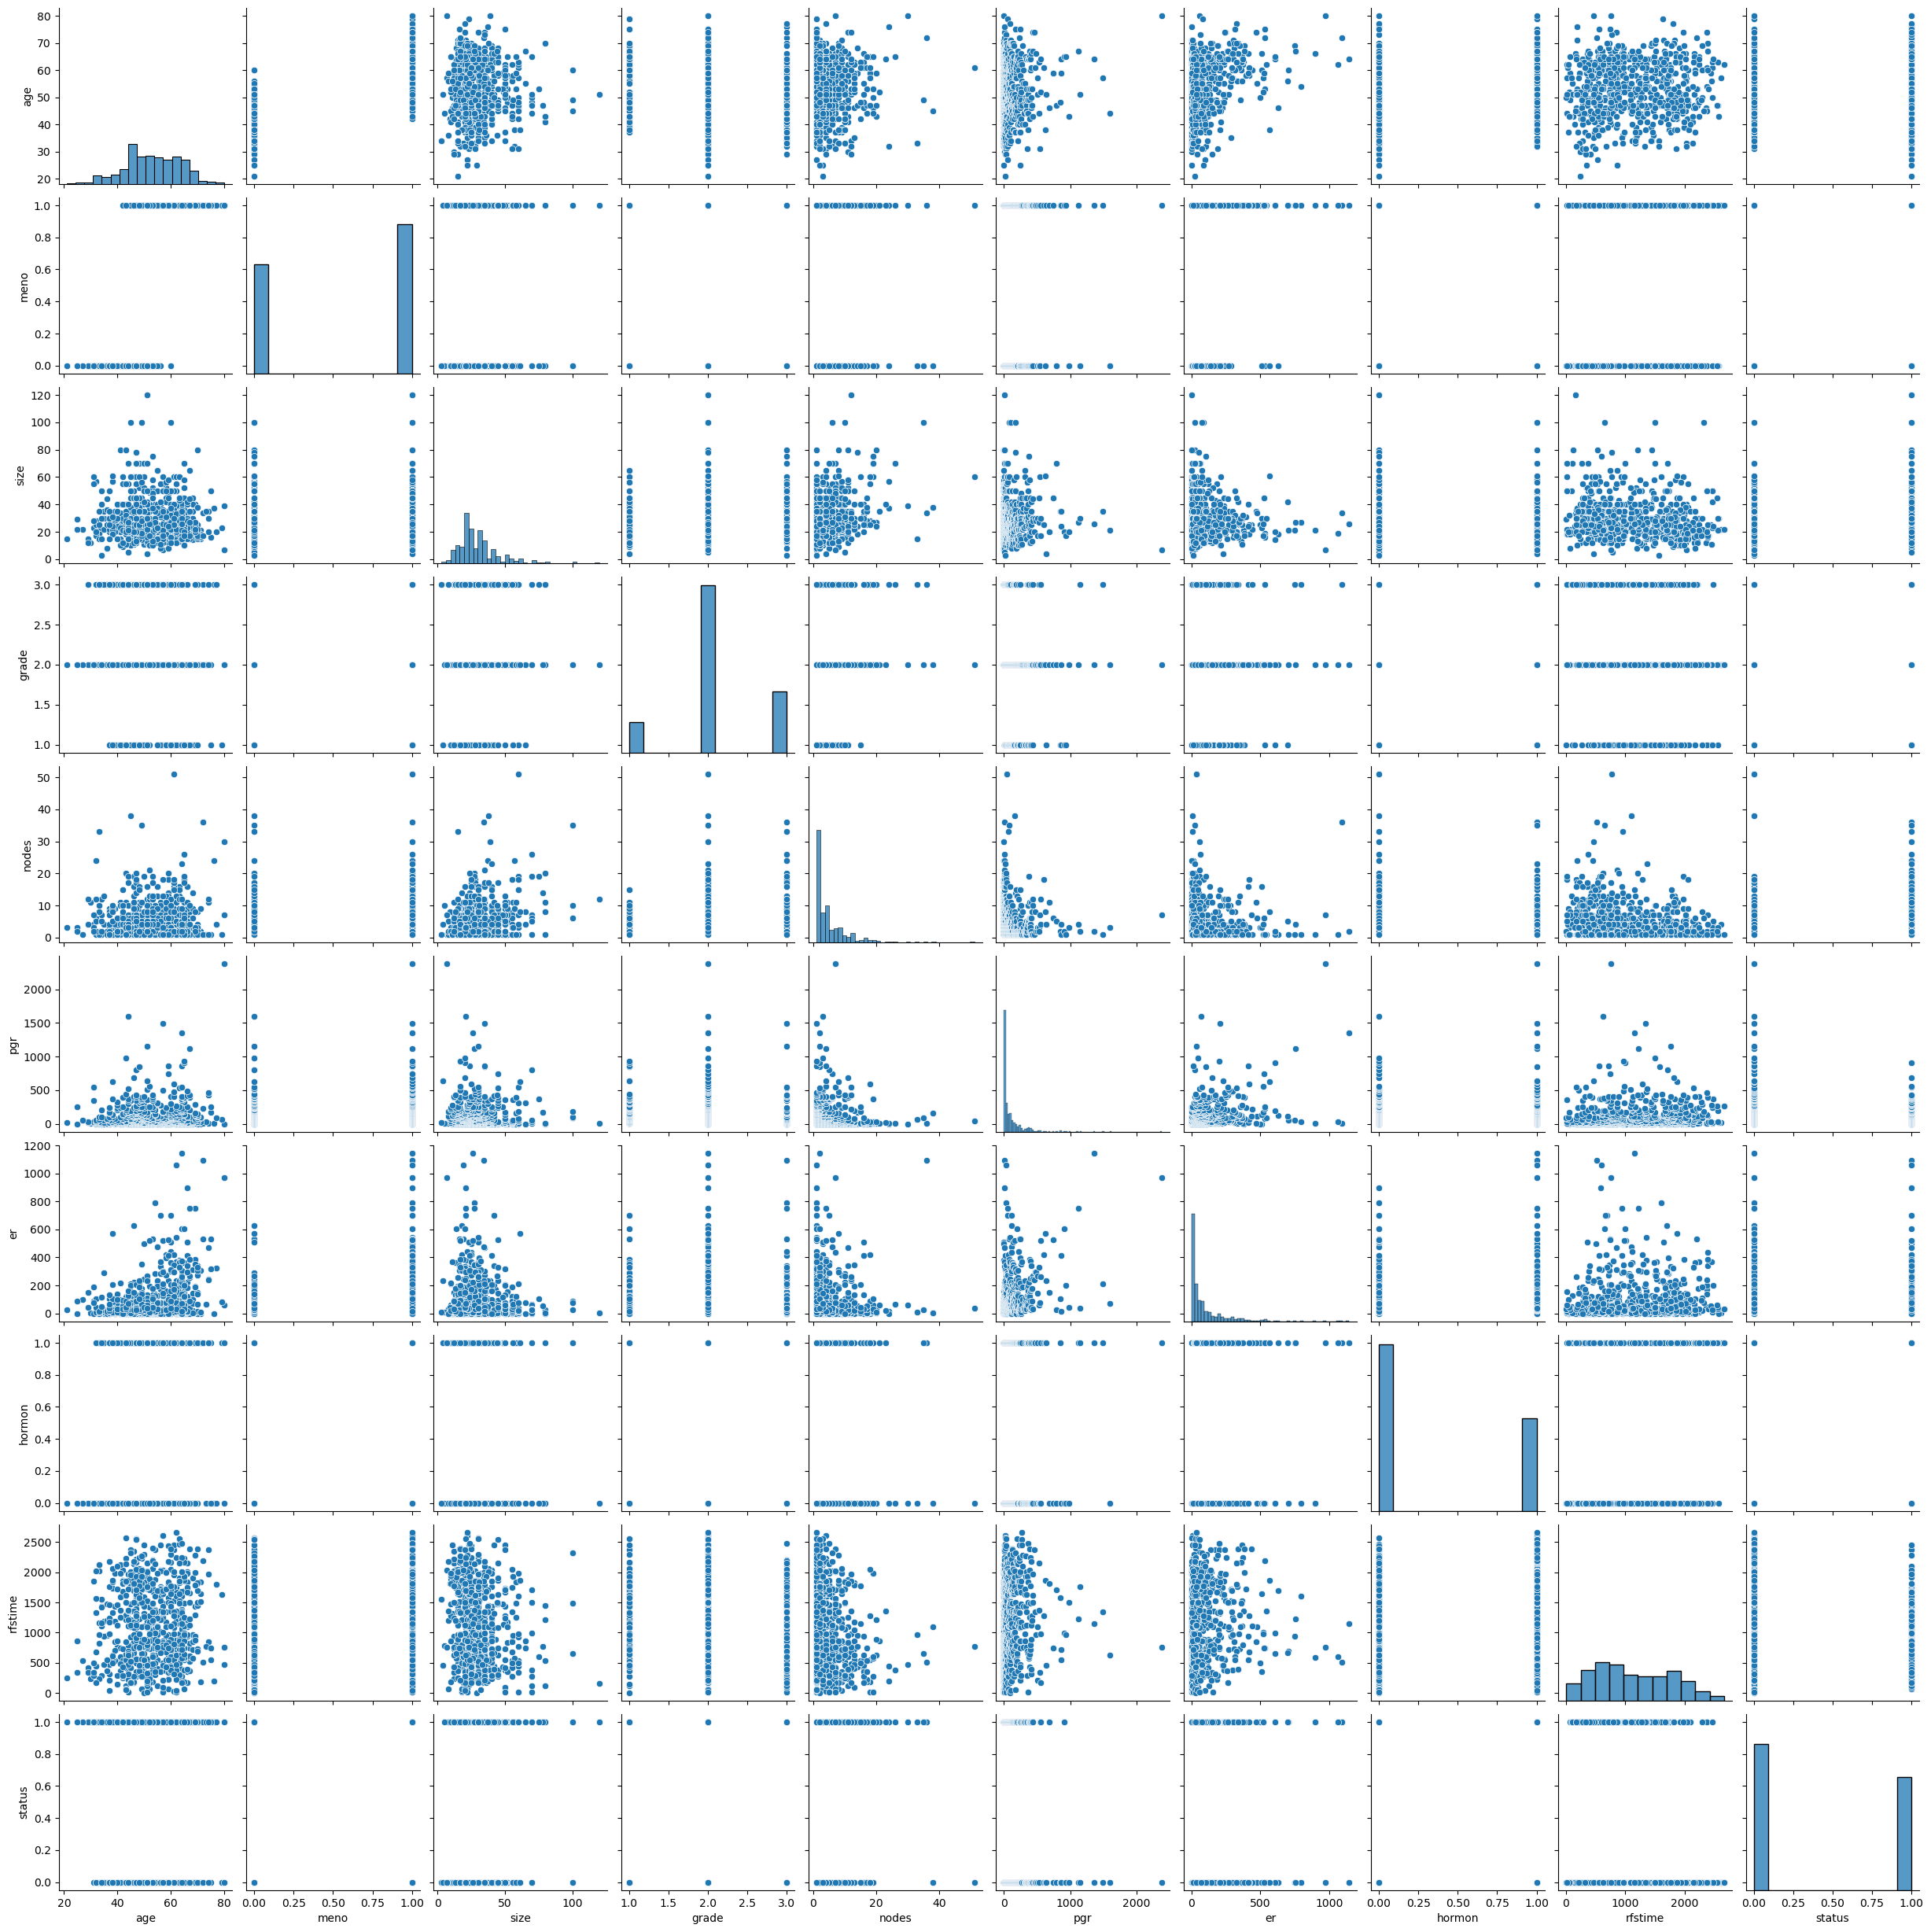

In [107]:
sns.pairplot(df)

plt.show()

# 2. Análise de sobrevivência

## Análise de sobrevivência

Entender fatores de riscos ou prognósticos para evolução e piora dos casos de câncer de mama

Caracterização do nosso problema:
1. Evento: Recidiva ou morte
2. Tempo de estudo:
    - Tempo inicial: Remoção do tumor
    - Tempo para evento ou censura: Número de dias desde a cirurgia até evento/censura
3. Censura:
    - Censura do tipo aleatório e à direita: O paciente foi removido do estudo antes da ocorrência do evento (Recuperação ou teve o último acompanhamento). O tempo máximo permitido nesse experimento é de 5 anos. Além disso, o evento de interesse está a direita do tempo registrado

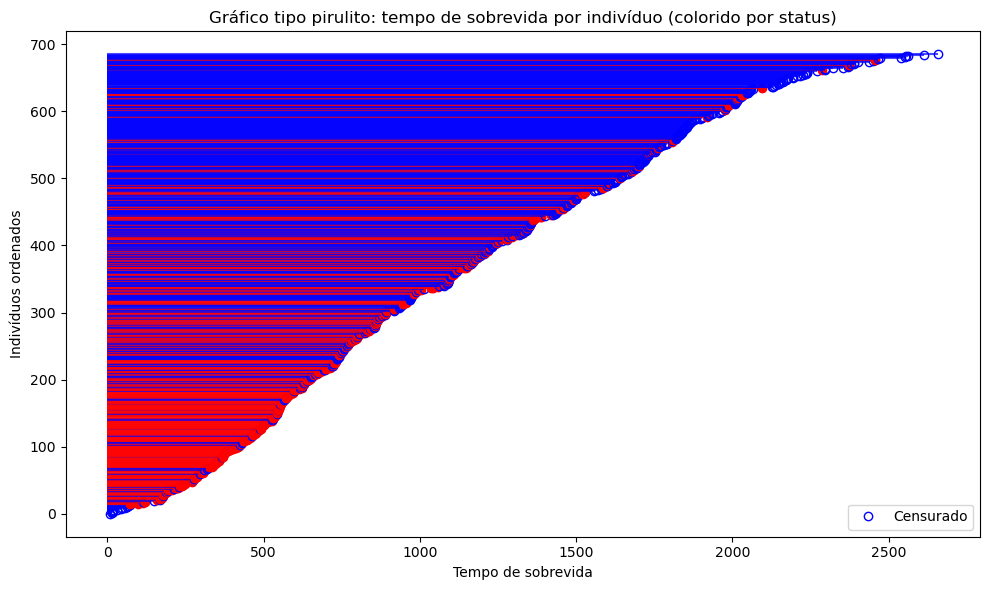

In [45]:
# Ordena os dados por tempo para um visual mais organizado
df_sorted = df.sort_values(by='rfstime').reset_index(drop=True)

# Define os valores do eixo Y como o índice dos pacientes
y_vals = df_sorted.index
x_vals = df_sorted['rfstime']
status = df_sorted['status']

fig, ax = plt.subplots(figsize=(10, 6))

# Desenha cada linha individualmente com a cor correspondente
for i in range(len(df_sorted)):
    color = 'red' if status[i] == 1 else 'blue'

    # Linha
    ax.hlines(y=y_vals[i], xmin=0, xmax=x_vals[i], color=color, alpha=0.7)

    # Bolinha no fim
    if status[i] == 1:  # Evento
        ax.plot(x_vals[i], y_vals[i], 'o', color=color, label='Evento' if i == 0 else "")
    else:  # Censura
        ax.plot(x_vals[i], y_vals[i], 'o', markerfacecolor='none', markeredgecolor=color, label='Censurado' if i == 0 else "")

# Ajustes visuais
ax.set_xlabel('Tempo de sobrevida')
ax.set_ylabel('Indivíduos ordenados')
ax.set_title('Gráfico tipo pirulito: tempo de sobrevida por indivíduo (colorido por status)')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [53]:
kmf = KaplanMeierFitter()
kmf = kmf.fit(df["rfstime"], event_observed=df["status"])

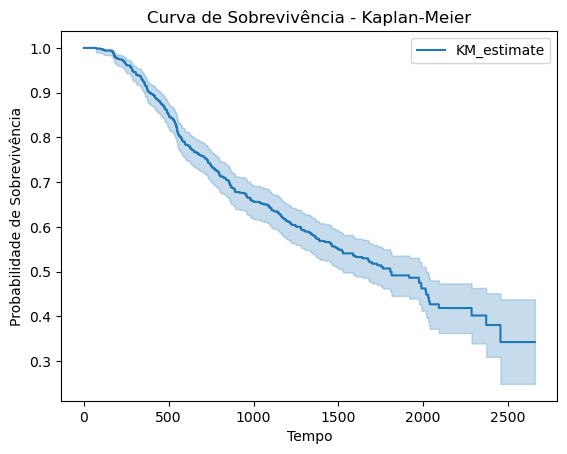

In [16]:
kmf.plot_survival_function()
plt.title("Curva de Sobrevivência - Kaplan-Meier")
plt.xlabel("Tempo")
plt.ylabel("Probabilidade de Sobrevivência")
plt.show()

In [49]:
f"Estimativa de tempo {kmf.median_survival_time_} dias, em que 50% dos pacientes não terão tido recorrência ou morte. (Survived)"

'Estimativa de tempo 1807.0 dias, em que 50% dos pacientes não terão tido recorrência ou morte. (Survived)'

In [ ]:
# Considerando tempo máximo = 5 anos
mean_survival_time = restricted_mean_survival_time(kmf, t=1825)
print("Tempo médio de sobrevivência estimado:", mean_survival_time)

Tempo médio de sobrevivência estimado: 1318.417104179723


In [40]:
kmf_summary_df = pd.concat([kmf.survival_function_, kmf.confidence_interval_], axis=1)

In [62]:
kmf_summary_df.head(8)

,KM_estimate,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.0,1.0,1.0,1.0
8.0,1.0,1.0,1.0
15.0,1.0,1.0,1.0
16.0,1.0,1.0,1.0
17.0,1.0,1.0,1.0
18.0,1.0,1.0,1.0
29.0,1.0,1.0,1.0
42.0,1.0,1.0,1.0


## Comparando as curvas de sobrevivência considerando diferentes categorias

In [81]:
from itertools import combinations

In [82]:
def comparar_sobrevivencia_multigrupo(df, time_col, event_col, cat_col):
    categorias = df[cat_col].dropna().unique()
    resultados = []

    for cat_1, cat_2 in combinations(categorias, 2):
        grupo_1 = df[df[cat_col] == cat_1]
        grupo_2 = df[df[cat_col] == cat_2]

        result = logrank_test(
            durations_A=grupo_1[time_col],
            durations_B=grupo_2[time_col],
            event_observed_A=grupo_1[event_col],
            event_observed_B=grupo_2[event_col]
        )

        resultados.append({
            'cat_1': cat_1,
            'cat_2': cat_2,
            't_0': result._kwargs['t_0'],
            'p_value': result.p_value,
            'test_statistic': result.test_statistic
        })

    return pd.DataFrame(resultados)

### FEATURE: Idade

In [64]:
bins = [0, 39, 59, float('inf')]
labels = ['Jovem (<40)', 'Adulto (40–59)', 'Idoso (60+)']

df['age_cat'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

In [66]:
df['age_cat'].value_counts()

age_cat
Adulto (40–59)    410
Idoso (60+)       211
Jovem (<40)        65
Name: count, dtype: int64

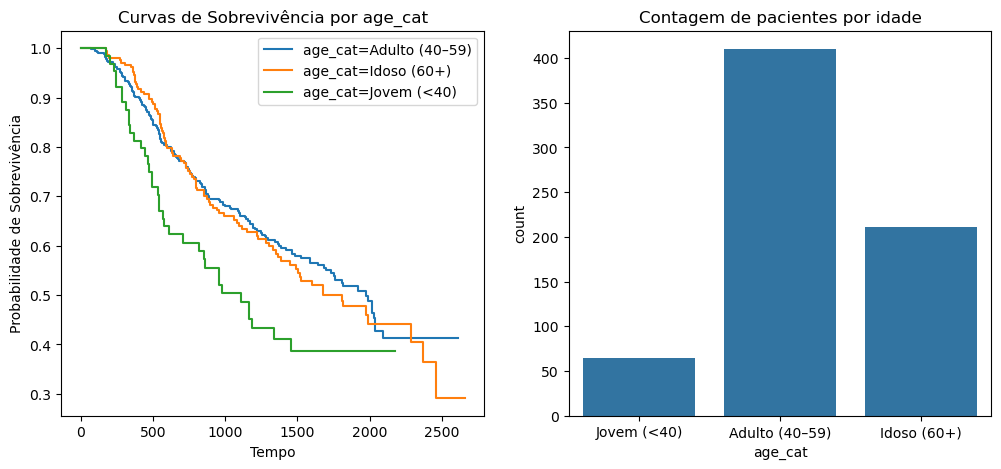

In [118]:
grupo_col = "age_cat"  # qualquer variável categórica

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1,2)

ax_0= fig.add_subplot(gs[0,0])

for grupo in df[grupo_col].unique():
    kmf = KaplanMeierFitter()
    mask = df[grupo_col] == grupo
    kmf.fit(df[mask]["rfstime"], event_observed=df[mask]["status"], label=f"{grupo_col}={grupo}")
    kmf.plot_survival_function(ax=ax_0,ci_show=False)

plt.title(f"Curvas de Sobrevivência por {grupo_col}")
plt.xlabel("Tempo")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()


ax_1 = fig.add_subplot(gs[0,1])
ax_1.set_title("Contagem de pacientes por idade")
sns.countplot(df, x='age_cat', ax=ax_1)

plt.show()

In [83]:
results_df = comparar_sobrevivencia_multigrupo(df=df, time_col='rfstime',event_col='status',cat_col='age_cat')

In [84]:
results_df

,cat_1,cat_2,t_0,p_value,test_statistic
0,Adulto (40–59),Idoso (60+),-1,0.655658,0.198841
1,Adulto (40–59),Jovem (<40),-1,0.009293,6.765591
2,Idoso (60+),Jovem (<40),-1,0.024387,5.066887


### FEATURE: Meno

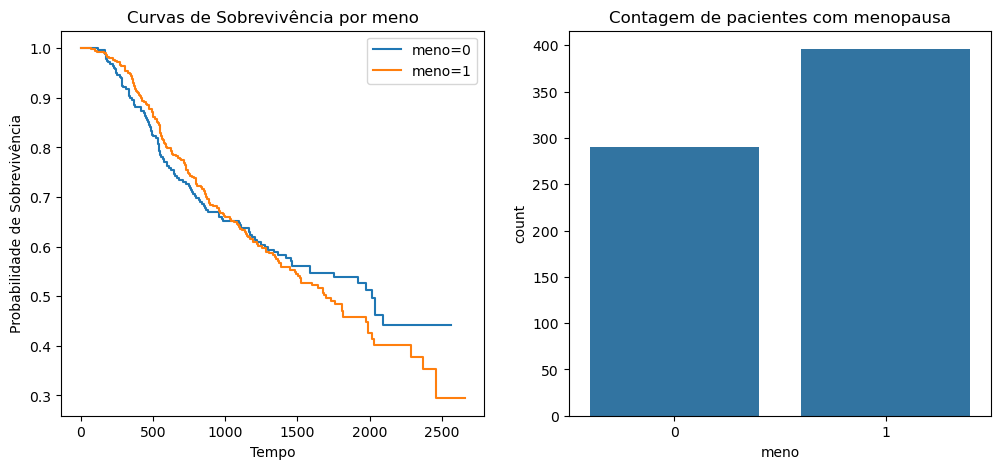

In [119]:
grupo_col = "meno"  # qualquer variável categórica

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1,2)

ax_0= fig.add_subplot(gs[0,0])

for grupo in df[grupo_col].unique():
    kmf = KaplanMeierFitter()
    mask = df[grupo_col] == grupo
    kmf.fit(df[mask]["rfstime"], event_observed=df[mask]["status"], label=f"{grupo_col}={grupo}")
    kmf.plot_survival_function(ax=ax_0,ci_show=False)

plt.title(f"Curvas de Sobrevivência por {grupo_col}")
plt.xlabel("Tempo")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()

ax_1 = fig.add_subplot(gs[0,1])
ax_1.set_title("Contagem de pacientes com menopausa")
sns.countplot(df, x='meno', ax=ax_1)

plt.show()

In [85]:
results_df = comparar_sobrevivencia_multigrupo(df=df, time_col='rfstime',event_col='status',cat_col='hormon')

In [86]:
results_df

,cat_1,cat_2,t_0,p_value,test_statistic
0,0,1,-1,0.003427,8.564781


### FEATURE: Grau

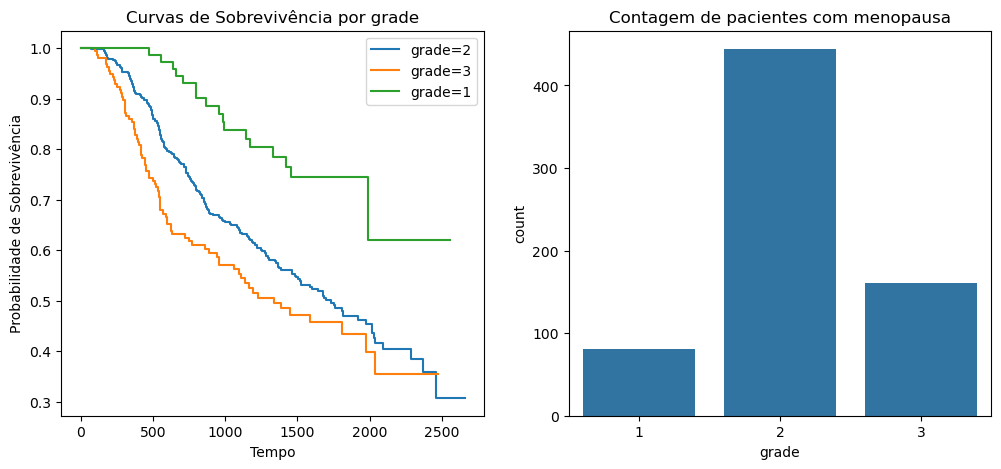

In [120]:
grupo_col = "grade"  # qualquer variável categórica

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1,2)

ax_0= fig.add_subplot(gs[0,0])

for grupo in df[grupo_col].unique():
    kmf = KaplanMeierFitter()
    mask = df[grupo_col] == grupo
    kmf.fit(df[mask]["rfstime"], event_observed=df[mask]["status"], label=f"{grupo_col}={grupo}")
    kmf.plot_survival_function(ax=ax_0,ci_show=False)

plt.title(f"Curvas de Sobrevivência por {grupo_col}")
plt.xlabel("Tempo")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()

ax_1 = fig.add_subplot(gs[0,1])
ax_1.set_title("Contagem de pacientes com menopausa")
sns.countplot(df, x='grade', ax=ax_1)

plt.show()

In [94]:
results_df = comparar_sobrevivencia_multigrupo(df=df, time_col='rfstime',event_col='status',cat_col='grade')
results_df

,cat_1,cat_2,t_0,p_value,test_statistic
0,2,3,-1,0.035374,4.427015
1,2,1,-1,0.000218,13.671903
2,3,1,-1,0.000009,19.815191


### FEATURE: Tratamento hormonal

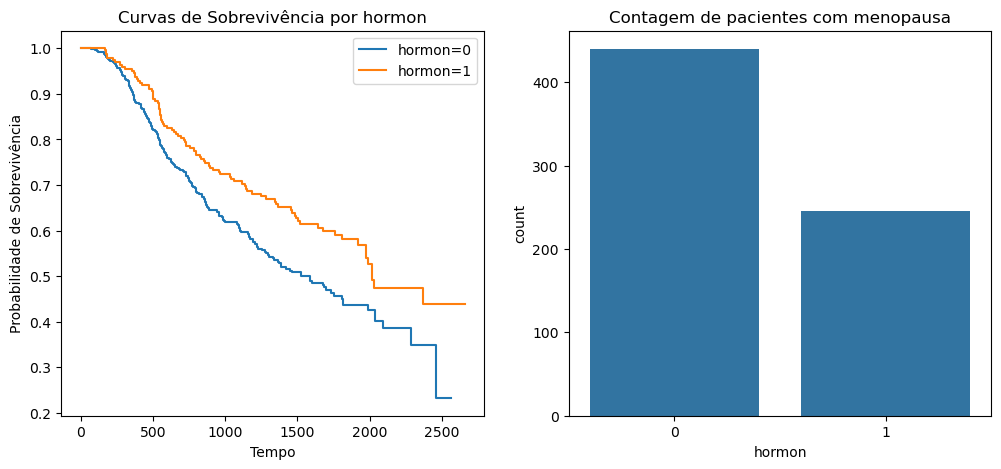

In [121]:
grupo_col = "hormon"  # qualquer variável categórica

fig = plt.figure(figsize=(12,5))
gs = fig.add_gridspec(1,2)

ax_0= fig.add_subplot(gs[0,0])

for grupo in df[grupo_col].unique():
    kmf = KaplanMeierFitter()
    mask = df[grupo_col] == grupo
    kmf.fit(df[mask]["rfstime"], event_observed=df[mask]["status"], label=f"{grupo_col}={grupo}")
    kmf.plot_survival_function(ax=ax_0,ci_show=False)

plt.title(f"Curvas de Sobrevivência por {grupo_col}")
plt.xlabel("Tempo")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()

ax_1 = fig.add_subplot(gs[0,1])
ax_1.set_title("Contagem de pacientes com menopausa")
sns.countplot(df, x=grupo_col, ax=ax_1)

plt.show()

In [96]:
results_df = comparar_sobrevivencia_multigrupo(df=df, time_col='rfstime',event_col='status',cat_col=grupo_col)
results_df

,cat_1,cat_2,t_0,p_value,test_statistic
0,0,1,-1,0.003427,8.564781


## Métodos paramétricos

In [109]:
# Dados
T = df["rfstime"]           # tempo até o evento ou censura
E = df["status"]            # 1 = evento ocorreu, 0 = censurado

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

# Weibull
wf = WeibullFitter()
wf.fit(T, event_observed=E)
wf.print_summary()

# Log-Normal
lnf = LogNormalFitter()
lnf.fit(T, event_observed=E)
lnf.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 686 total observations, 387 right-censored observations>
   number of observations = 686
number of events observed = 299
           log-likelihood = -2637.28
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 2259.85    114.89         2034.68         2485.03
rho_       1.27      0.06            1.15            1.40

         cmp to     z      p  -log2(p)
lambda_    1.00 19.66 <0.005    283.48
rho_       1.00  4.29 <0.005     15.78
---
AIC = 5278.55

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 686 total observations, 387 right-censored observations>
   number of observations = 686
number of events observed = 299
           log-likelihood = -2618.89
               hypothesis = mu_ != 0, sigma_ != 1

---
        coef  se(coef)  coef lower 95%  coef upper 95%
mu_     7.42      0.06            7.31            7.53
sigma_  1.11      0.05            1.02            1.21

        cmp to      z      p  -log2(p)
mu_       0.00 131.50 <0.005       inf
sigma_    1.00   2.28   0.02      5.47
---
AIC = 5241.77

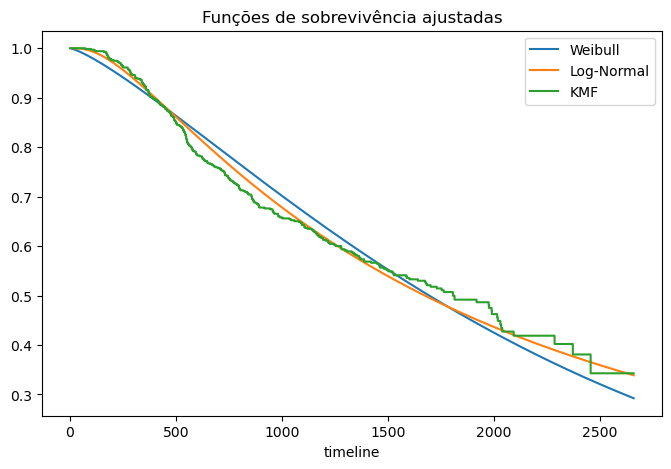

In [111]:
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(1,1)
ax = fig.add_subplot(gs[0,0])

wf.plot_survival_function(label="Weibull", ax=ax,ci_show=False)
lnf.plot_survival_function(label="Log-Normal", ax=ax,ci_show=False)
kmf.plot_survival_function(label="KMF", ax=ax,ci_show=False)

plt.title("Funções de sobrevivência ajustadas")
plt.legend()
plt.show()

In [113]:
# Tempos onde a função de sobrevivência é definida
times = kmf.survival_function_.index

# Valores das funções de sobrevivência
S_km = kmf.survival_function_["KM_estimate"].values
S_wf = wf.survival_function_at_times(times).values
S_logn = lnf.survival_function_at_times(times).values

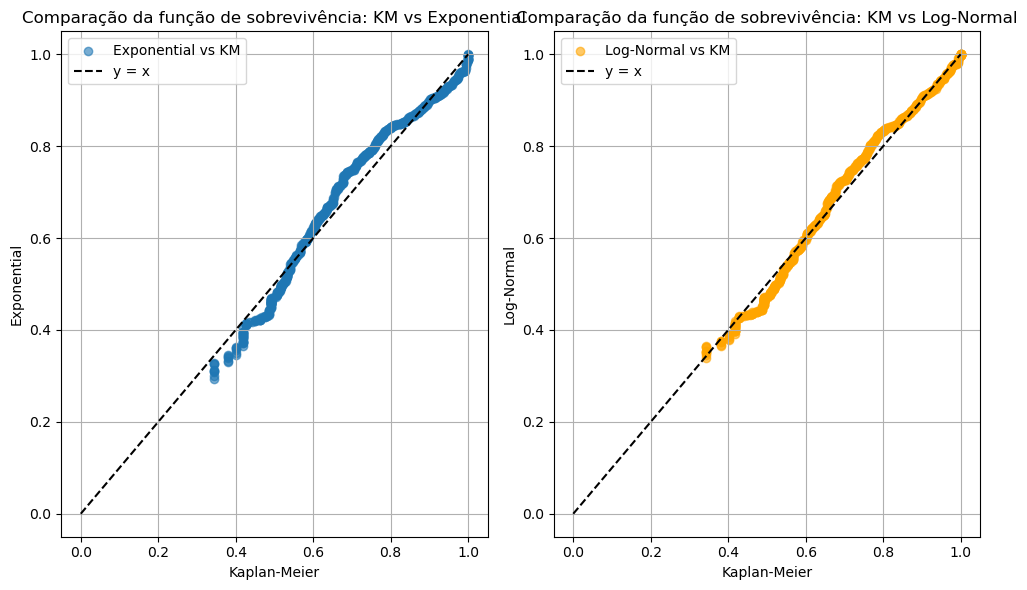

In [117]:
# KM vs Exponential
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(1,2)
ax_0 = fig.add_subplot(gs[0,0])

ax_0.scatter(S_km, S_wf, alpha=0.6, label="Exponential vs KM")
ax_0.plot([0, 1], [0, 1], 'k--', label='y = x')
ax_0.set_xlabel("Kaplan-Meier")
ax_0.set_ylabel("Exponential")
ax_0.set_title("Comparação da função de sobrevivência: KM vs Exponential")
ax_0.legend()
ax_0.grid(True)

# KM vs Log-Normal
ax_1 = fig.add_subplot(gs[0,1])
ax_1.scatter(S_km, S_logn, alpha=0.6, label="Log-Normal vs KM", color='orange')
ax_1.plot([0, 1], [0, 1], 'k--', label='y = x')
ax_1.set_xlabel("Kaplan-Meier")
ax_1.set_ylabel("Log-Normal")
ax_1.set_title("Comparação da função de sobrevivência: KM vs Log-Normal")
ax_1.legend()
ax_1.grid(True)

plt.tight_layout()
plt.show()

## Regressão de Cox

In [6]:
cph = CoxPHFitter()

In [7]:
cph.fit(df[['grade','age','rfstime','status']], duration_col='rfstime', event_col='status')

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>

In [8]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'rfstime'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1777.98
         time fit was run = 2025-08-02 16:27:42 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
grade      0.45      1.56      0.10            0.25            0.64                1.28                1.90
age       -0.00      1.00      0.01           -0.01            0.01                0.99                1.01

           cmp to     z      p  -log2(p)
covariate                               
grade        0.00  4.43 <0.005     16.67
age          0.00 -0.51   0.61      0.72
---
Concordance = 0.59
Partial AIC = 3559.96
log-likelihood ratio test = 20.25 on 2 df
-log2(p) of ll-ratio test = 14.61

<Axes: xlabel='log(HR) (95% CI)'>

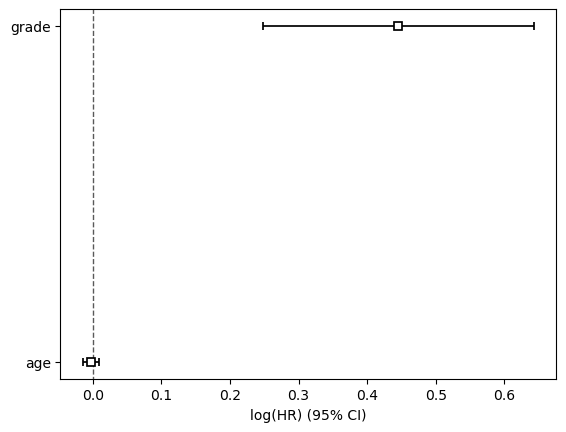

In [9]:
cph.plot()

<Axes: >

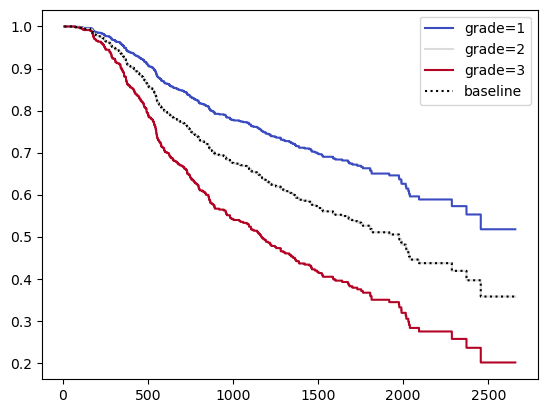

In [10]:
cph.plot_partial_effects_on_outcome(covariates='grade', values=[1,2,3], cmap='coolwarm')

<Axes: >

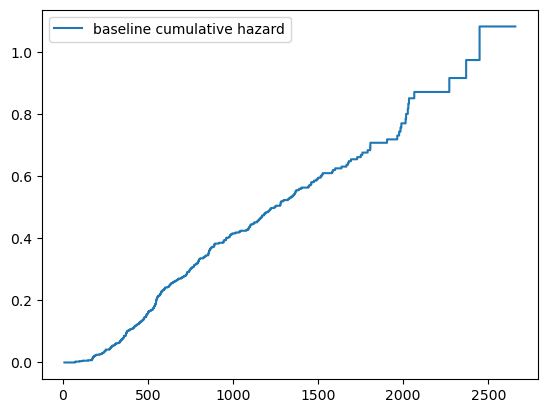

In [11]:
cph.baseline_cumulative_hazard_.plot(drawstyle="steps")

### Incorporando todas as features

In [12]:
cph = CoxPHFitter()
cph.fit(df, duration_col='rfstime', event_col='status')

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>

In [13]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'rfstime'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1737.17
         time fit was run = 2025-08-02 16:27:42 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
meno       0.27      1.31      0.18           -0.09            0.63                0.91                1.87
size       0.01      1.01      0.00           -0.00            0.02                1.00                1.02
grade      0.28      1.32      0.11            0.07            0.49                1.08                1.63
nodes      0.05      1.05      0.01            0.04            0.06                1.04                1.07
pgr       -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
er         0.00      1.00      0.00           -0.00            0.00                1.00                1.00
hormon    -0.34      0.71      0.13           -0.59           -0.08                0.55                0.92

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -1.01   0.31      1.68
meno         0.00  1.46   0.14      2.79
size         0.00  1.95   0.05      4.30
grade        0.00  2.64   0.01      6.93
nodes        0.00  6.73 <0.005     35.82
pgr          0.00 -3.89 <0.005     13.26
er           0.00  0.37   0.71      0.50
hormon       0.00 -2.61   0.01      6.81
---
Concordance = 0.69
Partial AIC = 3490.35
log-likelihood ratio test = 101.86 on 8 df
-log2(p) of ll-ratio test = 58.96

<Axes: xlabel='log(HR) (95% CI)'>

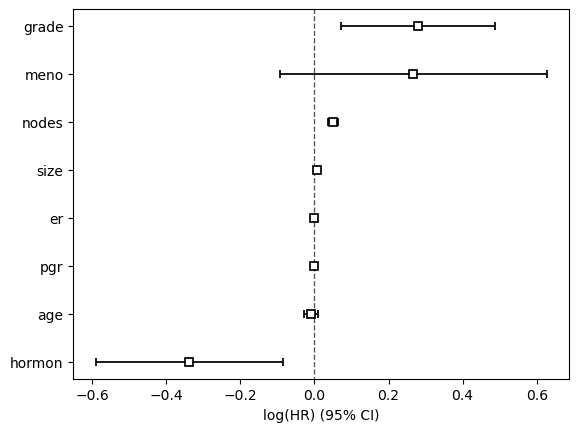

In [14]:
cph.plot()

<Axes: >

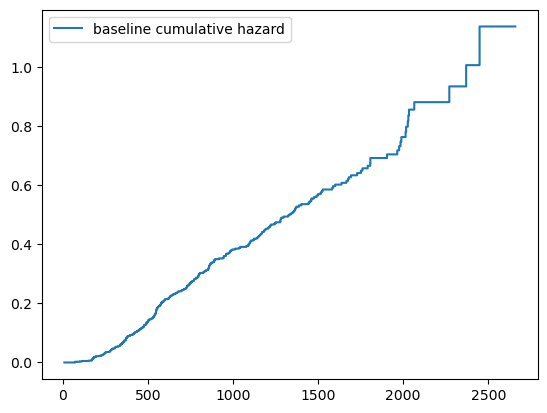

In [16]:
cph.baseline_cumulative_hazard_.plot(drawstyle="steps")